## Variational Auto-Encoder (VAE) PyTorch implementation
Evolution of the auto-encoder neural network to reduce dimensionality of an airfoil defined by 30 coordinates.  
Papers:
- Larsen et al.: "Autoencoding beyond pixels using a learned similarity metric" - https://arxiv.org/abs/1512.09300
- Wang et al.: "Airfoil GAN: Encoding and Synthesizing Airfoils forAerodynamic-aware Shape Optimization" - https://arxiv.org/abs/2101.04757

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from types_ import *

plt.style.use('seaborn-whitegrid')

In [2]:
# Library options
pd.options.mode.chained_assignment = None  # default='warn'

# Get CPU or GPU device for NN
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
print(f"CUDA version: {torch.version.cuda}")

Using cuda device
CUDA version: 10.2


### Helper functions

In [3]:
def airfoil_plot(airfoil_coords, fig=None, label=None, spacing='cosine', n_points=30):
    """
    Returns a plot of an airfoil. Used to visualize output of the optimizer. 
    Assumes 15 points for upper surface and 15 points for lower surface, with cosine spacing.
    NOTE: This function should be edited depending on the database.
    Inputs:
        - airfoil_coords: pandas DataFrame with airfoil coordinates and other parameters
    Outputs:
        - Plot of airfoil shape
    """
    if fig==None:
        fig = plt.subplot2grid((1,3), (0,0), colspan = 3)
    
    # X coordinates
    points_per_surf = int(n_points/2)
    if spacing == 'cosine':
        x = list(reversed([0.5*(1-np.cos(ang)) for ang in np.linspace(0,np.pi,points_per_surf+2)]))
        aux_x = list([0.5*(1-np.cos(ang)) for ang in np.linspace(0,np.pi,points_per_surf+2)[1:points_per_surf+1]])
        [x.append(i) for i in aux_x]
        x.append(1)
    elif spacing == 'linear':
        x = list(reversed(list(np.linspace(0,1,points_per_surf+2))))
        aux_x = list(list(np.linspace(0,1,points_per_surf+2)[1:points_per_surf+1]))
        [x.append(i) for i in aux_x]
        x.append(1)    

    # Y coordinates
    y = []
    origin = (airfoil_coords.iloc[0][0]+airfoil_coords.iloc[0][points_per_surf])/2
    y.append(0)
    [y.append(j) for j in airfoil_coords.iloc[0][0:points_per_surf].values.tolist()]
    y.append(origin)
    #aux_y = list(reversed(airfoil_coords.iloc[points_per_surf:n_points].values.tolist()))
    aux_y = list(airfoil_coords.iloc[0][points_per_surf:n_points].values.tolist())
    [y.append(k) for k in aux_y]
    y.append(0)

    # Airfoil plot     
    fig.plot(x, y, label = label)
    fig.set_xlim([-0.1,1.1])
    fig.set_ylim([-0.2,0.3])
    fig.set_ylabel('$y/c$')
    fig.set_xlabel('$x/c$') 
    fig.set_title('Airfoil plot', fontsize=16)
    fig.legend()
    if fig==None:
        plt.show()
    return


def torch_test_split(X, y = None, test_size=0.2, seed=1234):
    """
    Returns a train and test set in PyTorch tensor format from a numpy array dataset.
    Inputs:
        - X: numpy array with input data. Each row is a training/testing sample and each column is a feature.
        - y: numpy array with output data. Each row is a training/testing sample and each column is an output.
        - test_size: proportion of the dataset to be used as test set.
        - seed: random seed for reproducibility.
    Outputs:
        - training_data: PyTorch tensor with training data.
        - test_data: PyTorch tensor with test data.
    """
    X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X, y, test_size=test_size, random_state=seed)
    X_train = torch.from_numpy(X_train_0).float()
    X_test = torch.from_numpy(X_test_0).float()
    y_train = torch.from_numpy(y_train_0).float()
    y_test = torch.from_numpy(y_test_0).float()
    training_data = []
    testing_data = []
    for i in range(len(X_train)):
        training_data.append((X_train[i], y_train[i]))
    for i in range(len(X_test)):
        testing_data.append((X_test[i], y_test[i]))
    return training_data, testing_data

def normalize_data (data, scaler):
    """
    Normalizes neural network inputs and outputs.
    Inputs:
        - data: data to be normalized. [np.array / pd.DataFrame]
        - scaler: pre-fitted scaler object.
    Outputs:
        - normalized data. [pd.DataFrame]
    """
    if type(data) == pd.DataFrame:
        data = data.to_numpy().reshape(-1,scaler.n_features_in_)
    elif type(data) == np.ndarray:
        data = data.reshape(-1,scaler.n_features_in_)
    else:
        raise(TypeError('Input data must be either a pd.DataFrame or a np.ndarray'))
    norm_data = pd.DataFrame(data = scaler.transform(data), columns = scaler.feature_names_in_)
    return norm_data

def denormalize_data (data, scaler):
    """
    Denormalizes neural network inputs and outputs.
    Inputs:
        - data: data to be denormalized. [np.array / pd.DataFrame]
        - scaler: pre-fitted scaler object.
    Outputs:
        - denormalized data. [pd.DataFrame]
    """
    if type(data) == pd.DataFrame:
        data = data.to_numpy().reshape(-1,scaler.n_features_in_)
    elif type(data) == np.ndarray:
        data = data.reshape(-1,scaler.n_features_in_)
    else:
        raise(TypeError('Input data must be either a pd.DataFrame or a np.ndarray'))
    denorm_data = pd.DataFrame(data = scaler.inverse_transform(data), columns = scaler.feature_names_in_)
    return denorm_data


### Input data analysis

In [4]:
# Define input dataset (.csv) name and path
data_folder = './data/'
dataset_name = 'NACA4Digit_Dataset15Point.csv'
dataset_name = 'UIUC_dataset_198p.csv'

# Import dataset
airfoil_df = pd.read_csv(data_folder + dataset_name)
try:
    airfoil_df = airfoil_df.drop('Unnamed: 0', axis=1)    # Remove first column, counter
except: pass
num_coords = int(sum([1 for col in airfoil_df if col.startswith('y')]))
print(f'Number of airfoil coordinates: {num_coords}')
airfoil_df = airfoil_df.drop_duplicates(subset=['yU_1'], keep='first')    # Remove duplicate airfoil coordinates

airfoil_df.head()

Number of airfoil coordinates: 198


,yU_1,yU_2,yU_3,yU_4,yU_5,yU_6,yU_7,yU_8,yU_9,yU_10,...,yL_90,yL_91,yL_92,yL_93,yL_94,yL_95,yL_96,yL_97,yL_98,yL_99
0,0.000052,0.000207,0.000466,0.000828,0.001293,0.001860,0.002528,0.003298,0.004166,0.005133,...,0.002838,0.002308,0.001830,0.001406,0.001036,0.000721,0.000462,0.000261,0.000116,0.000029
1,0.000059,0.000235,0.000529,0.000938,0.001461,0.002096,0.002840,0.003691,0.004645,0.005697,...,0.001694,0.001380,0.001096,0.000843,0.000622,0.000433,0.000278,0.000157,0.000070,0.000017
2,0.000051,0.000204,0.000462,0.000829,0.001308,0.001905,0.002625,0.003470,0.004443,0.005543,...,0.001289,0.001060,0.000852,0.000664,0.000497,0.000351,0.000228,0.000130,0.000058,0.000015
3,0.000026,0.000105,0.000236,0.000420,0.000656,0.000943,0.001282,0.001669,0.002104,0.002581,...,-0.000372,-0.000303,-0.000240,-0.000185,-0.000137,-0.000096,-0.000062,-0.000035,-0.000016,-0.000004
4,0.000024,0.000095,0.000213,0.000380,0.000593,0.000854,0.001162,0.001514,0.001910,0.002347,...,-0.000223,-0.000178,-0.000138,-0.000103,-0.000073,-0.000050,-0.000031,-0.000017,-0.000007,-0.000002


## 2. Variational Autoencoder model
In this section, an MLP based variational encoder-decoder network will be created and trained to process airfoil coordinates and recreate them from a set of latent variables characterized by their mean $\mu$ and standard deviation $\sigma$.

**Inputs**
- Upper surface coordinates
- Lower surface coordinates

**Outputs**
- Approximately the same coordinates (network will be trained to do so)

There will be a layer in the middle that will encode the _latent feature_ distributions of the set. This is akin to a parameterization method, with arbitrary parameters.

In [5]:
# Data scaler fitting
scaler = MinMaxScaler()
scaler.fit(airfoil_df)

# Assemble a DataFrame with all the minimum and maximum values of each column
# For normalization and de-normalization. Gives an idea of the bounds.
scaler_bounds = pd.DataFrame(data = np.stack([scaler.feature_names_in_, scaler.data_min_, scaler.data_max_], axis=1), columns=['property', 'min', 'max'])

# Data normalization
airfoil_df_norm = normalize_data(airfoil_df, scaler)

# Input and "output" features
# Input and output features are both the same for this dataset.
try:
    X = airfoil_df_norm.drop(['Cl', 'Cd', 'Cm', 'ReynoldsNumber', 'MachNumber', 'alpha'], axis=1).values
except: 
    X = airfoil_df_norm.values

# Data tensors
training_data, test_data = torch_test_split(X, X, test_size=0.2)

# Data loaders
batch_size = 16

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {y.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([16, 198]) torch.float32
Shape of y: torch.Size([16, 198]) torch.float32


c:\Users\Usuario\.conda\envs\pytorchML\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


### 2.1 Creating models

In [43]:
# Define model - AirfoilVAE
from AirfoilVAE import AirfoilVAE
device = 'cuda'
latent_dim = 5
in_channels = num_coords
hidden_dims = [512, 256, 128, 64, 32]

model = AirfoilVAE(in_channels = in_channels,
                   latent_dim = latent_dim,
                   hidden_dims = hidden_dims).to(device)
print(model)

AirfoilVAE(
  (encoder): Sequential(
    (0): Linear(in_features=198, out_features=512, bias=True)
    (1): ELU(alpha=1.0)
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ELU(alpha=1.0)
    )
    (3): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ELU(alpha=1.0)
    )
    (4): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
    )
    (5): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ELU(alpha=1.0)
    )
  )
  (fc_mu): Linear(in_features=32, out_features=5, bias=True)
  (fc_var): Linear(in_features=32, out_features=5, bias=True)
  (decoder_input): Linear(in_features=5, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=128, bia

In [6]:
# Define model - BalancingVAE
from BalancingVAE import BalancingVAE
device = 'cuda'
latent_dim = 5
in_channels = num_coords
hidden_dims = [512, 256, 128, 64, 32]

model = BalancingVAE(in_channels = in_channels,
                   latent_dim = latent_dim,
                   hidden_dims = hidden_dims).to(device)

model.initialize_gamma(torch.stack([tens[0] for tens in training_data[:1000]]).to(device=device))
print(model)

BalancingVAE(
  (encoder): Sequential(
    (0): Linear(in_features=198, out_features=512, bias=True)
    (1): ELU(alpha=1.0)
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ELU(alpha=1.0)
    )
    (3): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ELU(alpha=1.0)
    )
    (4): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
    )
    (5): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ELU(alpha=1.0)
    )
  )
  (fc_mu): Linear(in_features=32, out_features=5, bias=True)
  (fc_var): Linear(in_features=32, out_features=5, bias=True)
  (decoder_input): Linear(in_features=5, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): ELU(alpha=1.0)
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=128, b

In [7]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [8]:
# Define train and test functions
def train(dataloader, model, loss_fn, optimizer, loss_output = None, recon_output = None, kld_output = None, weight = 1):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, weight = weight)

        # Backpropagation
        optimizer.zero_grad()
        loss['loss'].backward()
        optimizer.step()

        if batch % 2 == 0:
            losspr, current = loss['loss'].item(), batch * len(X)
            print(f"loss: {losspr:>7f}  [{current:>5d}/{size:>5d}]")
            
    if loss_output is not None:
        try:
            loss_output.append(loss['loss'].item())
            recon_output.append(loss['Reconstruction_Loss'].item())
            kld_output.append(loss['KLD'].item())
        except:
            loss_output.append(loss)
            
def test(dataloader, model, loss_fn, weight):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model.forward(X)
            test_loss += loss_fn(pred, weight = weight)['loss'].item()
    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n")

Epoch 1
-------------------------------
loss: 0.836876  [    0/ 1141]
loss: 0.778758  [   32/ 1141]
loss: 0.727241  [   64/ 1141]
loss: 0.607426  [   96/ 1141]
loss: 0.483569  [  128/ 1141]
loss: 0.399571  [  160/ 1141]
loss: 0.406379  [  192/ 1141]
loss: 0.370388  [  224/ 1141]
loss: 0.318654  [  256/ 1141]
loss: 0.313988  [  288/ 1141]
loss: 0.315053  [  320/ 1141]
loss: 0.298779  [  352/ 1141]
loss: 0.285361  [  384/ 1141]
loss: 0.274913  [  416/ 1141]
loss: 0.260182  [  448/ 1141]
loss: 0.256013  [  480/ 1141]
loss: 0.242053  [  512/ 1141]
loss: 0.232708  [  544/ 1141]
loss: 0.224244  [  576/ 1141]
loss: 0.213169  [  608/ 1141]
loss: 0.197049  [  640/ 1141]
loss: 0.187003  [  672/ 1141]
loss: 0.177394  [  704/ 1141]
loss: 0.166993  [  736/ 1141]
loss: 0.163853  [  768/ 1141]
loss: 0.147957  [  800/ 1141]
loss: 0.155536  [  832/ 1141]
loss: 0.133923  [  864/ 1141]
loss: 0.121540  [  896/ 1141]
loss: 0.108230  [  928/ 1141]
loss: 0.109870  [  960/ 1141]
loss: 0.100043  [  992/ 1141]


ValueError: x and y must have same first dimension, but have shapes (500,) and (1000,)

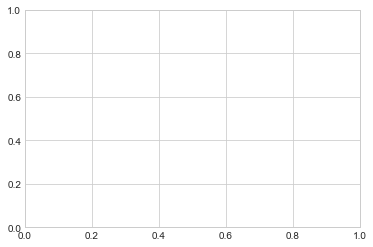

In [9]:
# Run training
epochs = 500
loss_plot = []
recon_plot = []
kld_plot = []
for t in range(epochs):
    kld_weight_coef = 1
    kld_weight = kld_weight_coef*(t/20 if t/20 <= 1 else 1)
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, model.loss_function, optimizer, loss_output = loss_plot, recon_output = recon_plot, kld_output = kld_plot, weight = kld_weight)
    test(test_dataloader, model, model.loss_function, weight = kld_weight)
print("Done!")

# Loss plot
plt.plot(range(1, epochs+1), loss_plot)
plt.ylabel('Loss')
plt.xlabel('Epoch') 
plt.title('Training loss', fontsize=16)
plt.xlim([0,epochs])
plt.show()

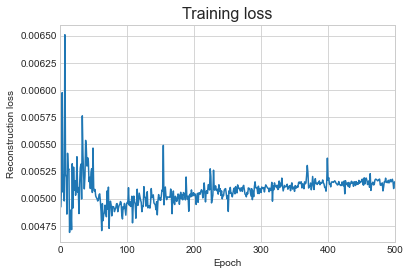

In [10]:
# Reconstruction loss plot
plt.plot(range(1, epochs+1), recon_plot)
plt.ylabel('Reconstruction loss')
plt.xlabel('Epoch') 
plt.title('Training loss', fontsize=16)
plt.xlim([0,epochs])
plt.show()

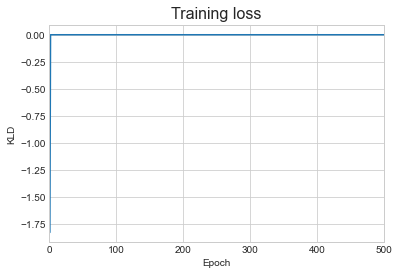

In [11]:
# KLD plot
plt.plot(range(1, epochs+1), kld_plot)
plt.ylabel('KLD')
plt.xlabel('Epoch') 
plt.title('Training loss', fontsize=16)
plt.xlim([0,epochs])
plt.show()

### 2.3 Saving the model

In [12]:
save_model = True
model_name = f'{model.name}_manual_{kld_weight_coef}.pth'

if save_model:
    trained_root = "./trained_models/"
    
    model_path = trained_root + model_name
    torch.save(model.state_dict(), model_path)
    print(f"Saved PyTorch Model State to {model_path}")

Saved PyTorch Model State to ./trained_models/VAE_MLP32_198_5_manual_1.pth


### 2.4 Loading the model

In [14]:
# For these sections, the CPU will be used
device = 'cpu'
model = AirfoilVAE(in_channels = in_channels,
            latent_dim = latent_dim,
            hidden_dims = hidden_dims).to(device)

model_root = "./trained_models/"
model_name = f'{model.name}_manual_{kld_weight_coef}.pth'

model_path = model_root + model_name
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

### 2.5 Making predictions on random airfoils

------ Comparison ------


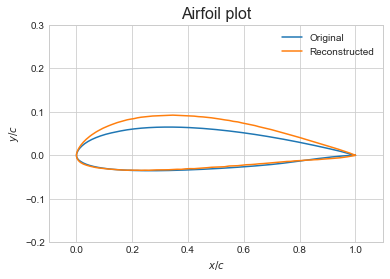

In [20]:
idxpred = np.random.randint(0, len(test_data))
x, y = test_data[idxpred][0].to(device), test_data[idxpred][1].to(device)
#dummy = np.array([0, 0, 0, 0, 0, 0]) # Dummy variable to complete the dataset rows to 36 for plotting
with torch.no_grad():
    pred = model.forward(x)     # Returns [recons, input, mu, log_var]
    reconstructed = denormalize_data(pred[0].cpu().numpy(),scaler)
    original = denormalize_data(pred[1].cpu().numpy(),scaler)
    plot1 = plt.subplot2grid((1,3), (0,0), colspan = 3)
    #print(f'mu: {pred[2].cpu().numpy()}')
    #print(f'std: {np.exp(0.5*pred[3].cpu().numpy())}')
    print("------ Comparison ------")
    airfoil_plot(original, fig=plot1, label="Original", n_points=num_coords, spacing='cosine')
    airfoil_plot(reconstructed, fig=plot1, label="Reconstructed", n_points=num_coords, spacing='cosine')
    plt.show()

### 2.6 Generating random airfoils

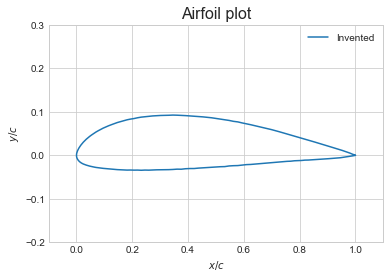

In [37]:
sampled = model.sample(1, 'cpu')
with torch.no_grad():
    sampled = model.sample(1, 'cpu')     # Returns [norm_coords] of an invented airfoil
    invented = denormalize_data(sampled[0].cpu().numpy(),scaler)
    airfoil_plot(invented, label="Invented", n_points=num_coords, spacing='cosine')
    plt.show()